In [1]:
import setup

In [2]:
from model.yolo_module import YOLOModule
from data.pixta_face_datamodule import PIXTAFaceDataModule
import torch

/home/qninhdt/miniconda3/envs/cctv-od/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = torch.load(
    "../checkpoints/yolo_nano/last.ckpt", map_location=torch.device("cpu")
)

data = PIXTAFaceDataModule(
    "../datasets/pixta_face/", batch_size=2, num_workers=4, pin_memory=True
)
data.setup()

In [4]:
model['lr_schedulers'][0]['max_num_iters'] = 100000
model['lr_schedulers'][0]['base_lrs'] = 0.05

In [5]:
torch.save(model, '../checkpoints/yolo_nano/last.ckpt')

In [19]:
loader = iter(data.test_dataloader())

In [20]:
from model.evaluators.postprocess import postprocess

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageDraw
from PIL import ImageFont
from torchvision.transforms.functional import to_pil_image

def unnormailze(image):
    image = image.cpu().numpy()
    image = image.transpose(1, 2, 0)
    image = image * [0.2272, 0.2248, 0.2345]
    image = image + [0.6596, 0.6235, 0.5875]
    image = image * 255
    image = image.astype('uint8')
    return image

def get_sample_image(image, sample):
    # convert torch tensor to PIL image
    image = to_pil_image(unnormailze(image.cpu()))

    draw = ImageDraw.Draw(image)

    for i in range(sample['boxes'].shape[0]):
        box = sample['boxes'][i]
        x, y, w, h = int(box[0]) - int(box[2]) / 2, int(box[1]) - int(box[3]) / 2, int(box[2]), int(box[3])

        color = 'red' if sample['gender'][i] == 0 else 'blue'

        draw.rectangle(((x, y), (x+w, y+h)), outline=color, width=3)

    return image

In [22]:
def visualize_sample(image, target, pred):
    # draw in 1x2 grid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.imshow(get_sample_image(image, target))
    ax1.set_title('Ground Truth')
    ax1.axis('off')

    ax2.imshow(get_sample_image(image, pred))
    ax2.set_title('Prediction')
    ax2.axis('off')

    plt.show()

[{'age': tensor([3], dtype=torch.int32), 'gender': tensor([1], dtype=torch.int32), 'race': tensor([1], dtype=torch.int32), 'emotion': tensor([1], dtype=torch.int32), 'masked': tensor([0], dtype=torch.int32), 'skintone': tensor([1], dtype=torch.int32), 'boxes': tensor([[310.4274, 219.0400,  71.1773,  91.2000]]), 'area': tensor([63392.2578])}, {'age': tensor([3], dtype=torch.int32), 'gender': tensor([1], dtype=torch.int32), 'race': tensor([1], dtype=torch.int32), 'emotion': tensor([1], dtype=torch.int32), 'masked': tensor([0], dtype=torch.int32), 'skintone': tensor([1], dtype=torch.int32), 'boxes': tensor([[246.4000, 289.8505,  72.9600,  86.8778]]), 'area': tensor([61900.4492])}]


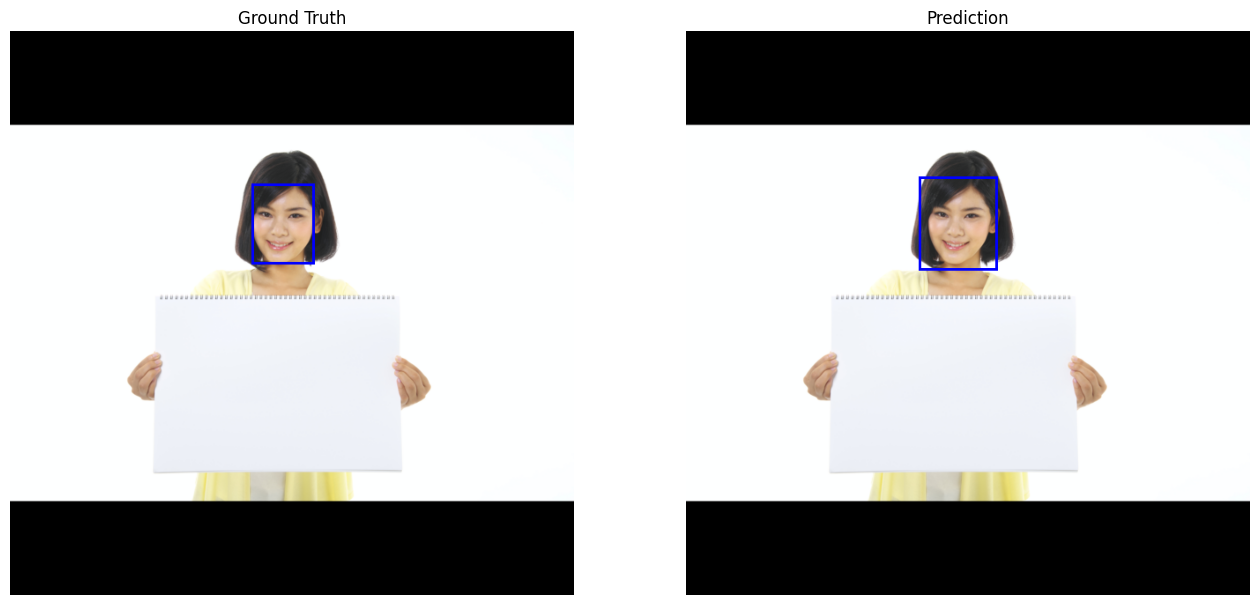

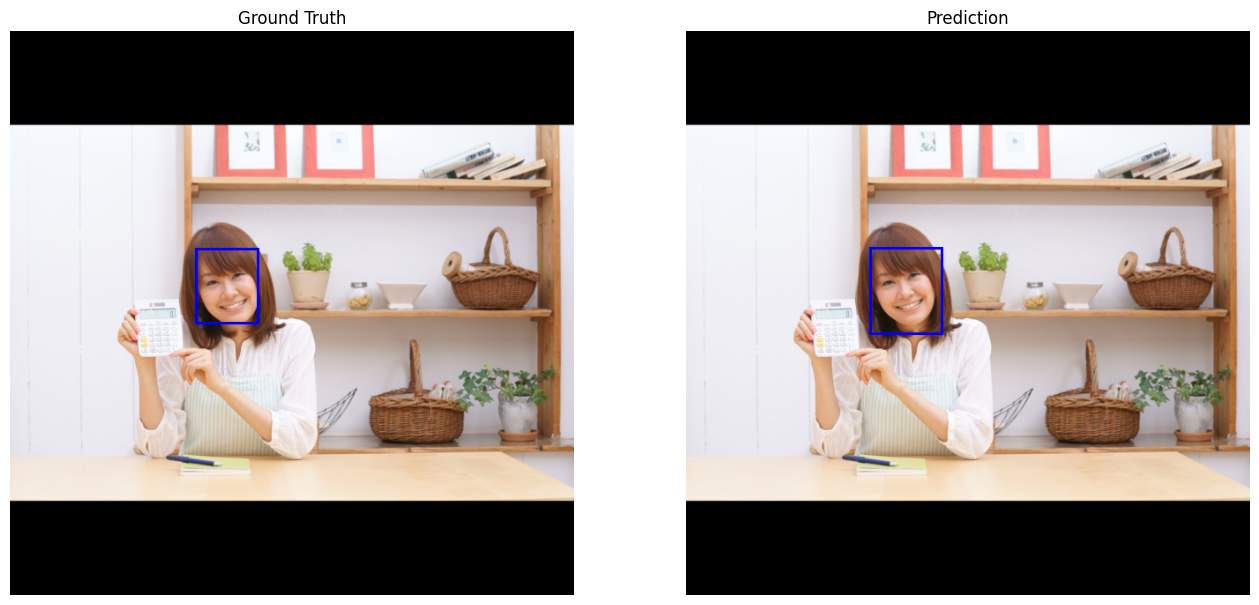

In [82]:
image, target = next(loader)

pred = model(image)[0]
pred = postprocess(pred, 0.2, 0.5)

print(target)

for i in range(len(pred)):
    visualize_sample(image[i], target[i], pred[i])
